### Overview

In this notebook, we undertake an extensive data consolidation exercise to analyze clickbait versus non-clickbait headlines. The consolidation encompasses two primary datasets, yielding a comprehensive compilation of 50,000 headlines. A detailed overview of these datasets is as follows:

#### 1. 2019/2020 Clickbait vs. Non-Clickbait Headline Dataset (20,000 Headlines)

- **Source and Data Collection**:
  - The non-clickbait data was meticulously gathered using APIs and web scraping techniques from reputable news sources including The New York Times, The Washington Post, The Guardian, Bloomberg, and Reuters.
  - The clickbait data was extracted from six prominent Twitter profiles, namely Buzzfeed, Examiner, ThePoliticalInsider, Upworthy, BoredPanda, and The Odyssey, known for their clickbait content.
- **Data Features**:
  - This dataset includes three primary features: the headline text (`Text`), a binary classification indicating clickbait (`Class`), and the publication date (`Date`).

#### 2. 2007 - 2016 Clickbait vs. Non-Clickbait Headline Dataset (30,000 Headlines)

- **Source and Data Collection**:
  - This dataset was sourced from [Kaggle](https://www.kaggle.com/amananandrai/clickbait-dataset) and includes data spanning a decade.
  - Non-clickbait headlines were sourced from The New York Times, The Guardian, The Hindu, and Wikinews.
  - Clickbait headlines were collected from BuzzFeed, Upworthy, ViralNova, Thatscoop, Scoopwhoop, and ViralStories.
- **Data Features**:
  - Similar to the first dataset, it comprises two features: the headline text (`Text`) and the binary clickbait classification (`Class`).

#### 3. Combined Dataset

- By merging the above two datasets, we have created a unified dataset, which provides an extensive basis for analyzing trends and patterns in clickbait versus non-clickbait headlines over different time periods.
- **Features**:
  - The consolidated dataset retains the headline text (`Text`) and the clickbait classification (`Class`), offering a broad spectrum for comparative analysis.

This comprehensive dataset amalgamation sets the stage for an in-depth exploration and analysis of headline characteristics, enabling the distinction between clickbait and non-clickbait content across diverse news sources and time frames.

# Consolidation & Cleaning

In [ ]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import re
from nltk.probability import FreqDist
from wordcloud import WordCloud
import string
from matplotlib import style

In [ ]:
# Set display options for pandas dataframes to enhance readability
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [ ]:
# Suppress warnings to avoid unnecessary clutter in output
warnings.filterwarnings('ignore')

In [ ]:
# Reading datasets of clickbait and non-clickbait headlines
clickbait_df = pd.read_csv('twitter_scraped_titles_clickbait.csv', index_col=0)
nytimes_df = pd.read_csv('nytimes_scraped_titles_nonclickbait.csv', index_col=0)
guardian_df = pd.read_csv('guardian_scraped_titles_nonclickbait.csv', index_col=0)
twp_df = pd.read_csv('twp_scraped_titles_nonclickbait.csv', index_col=0)
reuters_df = pd.read_csv('reuters_newsapi_scraped_titles_nonclickbait.csv', index_col=0)
bloomberg_df = pd.read_csv('bloomberg_newsapi_scraped_titles_nonclickbait.csv', index_col=0)

In [ ]:
# Assigning labels to the datasets: 1 for clickbait and 0 for non-clickbait
clickbait_df['class'] = 1
nytimes_df['class'] = 0
guardian_df['class'] = 0
twp_df.rename(columns={'title': 'text', 'published': 'date'}, inplace=True)
twp_df['class'] = 0
reuters_df['class'] = 0
bloomberg_df['class'] = 0

(11116, 3)

(5299, 3)

(3400, 3)

In [ ]:
# Merging all datasets into a single dataframe
all_headlines_df = pd.concat([clickbait_df, nytimes_df, guardian_df, twp_df, reuters_df, bloomberg_df])

In [ ]:
# Drop the 'date' column from the all_headlines_df dataframe
# This step is taken as the 'date' column may not be necessary for the intended analysis
all_headlines_df.drop(columns='date', inplace=True)

In [ ]:
# Retrieve the shape (number of rows and columns) of the all_headlines_df dataframe
# This is useful for confirming the dimensions of the dataset after dropping the column
all_headlines_df.shape

(20174, 3)

In [ ]:
# Export the all_headlines_df dataframe to a CSV file
all_headlines_df.to_csv('2019-20_all_scraped_titles_dataset.csv')

In [ ]:
# Reading and processing the second dataset
dataset2 = pd.read_csv('aman_rai_2007-16_clickbait_dataset.csv')
dataset2.rename(columns={'headline': 'text', 'clickbait': 'class'}, inplace=True)

In [ ]:
# Display the contents of 'dataset2'
dataset2

,text,class
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1
...,...,...
31995,"To Make Female Hearts Flutter in Iraq, Throw a...",0
31996,"British Liberal Democrat Patsy Calton, 56, die...",0
31997,Drone smartphone app to help heart attack vict...,0
31998,"Netanyahu Urges Pope Benedict, in Israel, to D...",0


In [ ]:
# Combining both datasets
df = pd.concat([all_headlines_df, dataset2])

In [ ]:
# Retrieve and display the shape (number of rows and columns) of the dataframe 'df'
df.shape

(52174, 2)

In [ ]:
# Calculate and display the counts of unique values in the 'class' column of 'df'
# This is particularly helpful in understanding the distribution between clickbait (e.g., class=1) and non-clickbait (e.g., class=0) headlines
df['class'].value_counts()

1    27115
0    25059
Name: class, dtype: int64

In [ ]:
# Export the dataframe 'df' to a CSV file.
df.to_csv('consolidated_dataset_without_engineered_features.csv')

# Feature Engineering

In [ ]:
#  Loads the dataset
df = pd.read_csv('consolidated_dataset_without_engineered_features.csv')

In [ ]:
# Function to clean and preprocess text data
def clean_text_round1(text):
    ''' Lowercase text, remove new lines, multiple spaces, URLs, square brackets, and punctuation. '''
    text = text.lower()
    text = re.sub('\n', ' ', text)
    text = re.sub('  ', ' ', text)
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('“|”|’|–|‘', '', text)
    return text

# Apply the text cleaning function
df['text'] = df['text'].apply(clean_text_round1)

In [ ]:
# Function to check if the headline is a question
def contains_question(headline):
    question_words = ['who', 'what', 'where', 'why', 'when', 'whose', 'whom', 'would', 'will', 'how', 'which', 'should', 'could', 'did', 'do']
    if "?" in headline or any(headline.startswith(word) for word in question_words):
        return 1
    else:
        return 0

# Apply function to create a new feature indicating if headline is a question
df['question'] = df['text'].apply(contains_question)

In [ ]:
# Count and display the frequency of values in the 'question' column of df
# This shows how many headlines are identified as questions versus not
df['question'].value_counts()

0    47388
1     4784
Name: question, dtype: int64

In [ ]:
# Function to check if the headline contains an exclamation mark
def contains_exclamation(headline):
    return 1 if "!" in headline else 0

# Apply function to create a new feature for exclamation mark presence
df['exclamation'] = df['text'].apply(contains_exclamation)

In [ ]:
# Count and display the frequency of values in the 'exclamation' column of df
# This indicates the number of headlines containing exclamation marks
df.exclamation.value_counts()

0    51614
1      558
Name: exclamation, dtype: int64

In [ ]:
# Define a lambda function 'feature_engineering_clean' to apply the 'clean_text_round1' function
# This is a concise way to apply text cleaning to each element in the 'text' column
feature_engineering_clean = lambda x: clean_text_round1(x)
df.text = pd.DataFrame(df.text.apply(feature_engineering_clean))


# Function to check if headline starts with a number
def starts_with_num(headline):
    return 1 if headline[0].isdigit() else 0

# Apply function to create a new feature for starting with a number
df['starts_with_num'] = df['text'].apply(starts_with_num)

In [ ]:
# Remove the column named 'Unnamed: 0' from the dataframe df
df.drop(columns='Unnamed: 0', inplace=True)

In [ ]:
# Create a feature that counts words in each headline
df['headline_words'] = df['text'].apply(lambda x: len(x.split()))

In [ ]:
# Remove headlines with zero words
df = df[df['headline_words'] != 0]
df

,text,class,question,exclamation,starts_with_num,headline_words
0,trey gowdy just humiliated adam schiff in fron...,1,0,0,0,10
1,60 netflix titles leaving in july 2020,1,0,0,1,7
2,learn how to make a green grape taste like a j...,1,0,1,0,22
3,the new july netflix titles are here and there...,1,0,0,0,13
4,the courts say sex discrimination laws protect...,1,0,0,0,19
...,...,...,...,...,...,...
52167,to make female hearts flutter in iraq throw a ...,0,0,0,0,10
52168,british liberal democrat patsy calton 56 dies ...,0,0,0,0,9
52169,drone smartphone app to help heart attack vict...,0,0,0,0,12
52170,netanyahu urges pope benedict in israel to den...,0,0,0,0,9


In [ ]:
# Save the dataframe with engineered features
df.to_csv('consolidated_dataset_with_engineered_features.csv')

# Exploratory Data Analysis

In [ ]:
# Install the 'wordcloud' package using pip
!pip install wordcloud

In [ ]:
# Tokenize text for further analysis
def tokenize(text):
    return [word.split() for word in text]

df['text'] = tokenize(df['text'])

# Define a list of stopwords for removal
stopwords_list = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# Remove stopwords from the tokenized text
df['text'] = df['text'].apply(lambda x: [item for item in x if item not in stopwords_list])

In [ ]:
# Separate dataframes for clickbait and non-clickbait for comparison
df_cb = df[df['class'] == 1]
df_noncb = df[df['class'] == 0]

In [ ]:
# Create a list of unique words for each class
cb_list = list(df_cb['text'])
noncb_list = list(df_noncb['text'])

# Generate a set of vocabulary for each class
total_vocab_cb = set(word for sublist in cb_list for word in sublist)
total_vocab_noncb = set(word for sublist in noncb_list for word in sublist)

20292

23485

In [ ]:
# Frequency distribution of words for each class
cb_freq = FreqDist(word for sublist in cb_list for word in sublist)
noncb_freq = FreqDist(word for sublist in noncb_list for word in sublist)

In [ ]:
# Calculate and retrieve the 20 most common words in clickbait headlines
# 'cb_freq' is a frequency distribution object for clickbait words
cb_freq.most_common(20)

[('people', 1745),
 ('things', 1416),
 ('make', 1038),
 ('know', 1005),
 ('new', 947),
 ('like', 809),
 ('17', 785),
 ('best', 733),
 ('actually', 730),
 ('21', 706),
 ('times', 658),
 ('based', 650),
 ('get', 644),
 ('need', 644),
 ('19', 640),
 ('coronavirus', 632),
 ('life', 591),
 ('heres', 586),
 ('one', 585),
 ('trump', 565)]

In [ ]:
# Calculate and retrieve the 20 most common words in non-clickbait headlines
# 'noncb_freq' is a frequency distribution object for non-clickbait words
noncb_freq.most_common(20)

[('us', 1483),
 ('new', 1259),
 ('police', 598),
 ('uk', 545),
 ('says', 501),
 ('dies', 492),
 ('coronavirus', 459),
 ('election', 432),
 ('trump', 423),
 ('dead', 404),
 ('first', 381),
 ('killed', 373),
 ('results', 339),
 ('china', 337),
 ('president', 330),
 ('court', 325),
 ('primary', 322),
 ('two', 319),
 ('world', 316),
 ('australian', 308)]

In [ ]:
# Extract the word counts and words for the top 20 clickbait words for visualization
cb_bar_counts = [x[1] for x in cb_freq.most_common(20)]
cb_bar_words = [x[0] for x in cb_freq.most_common(20)]

# Extract the word counts and words for the top 20 non-clickbait words for visualization
noncb_bar_counts = [x[1] for x in noncb_freq.most_common(20)]
noncb_bar_words = [x[0] for x in noncb_freq.most_common(20)]

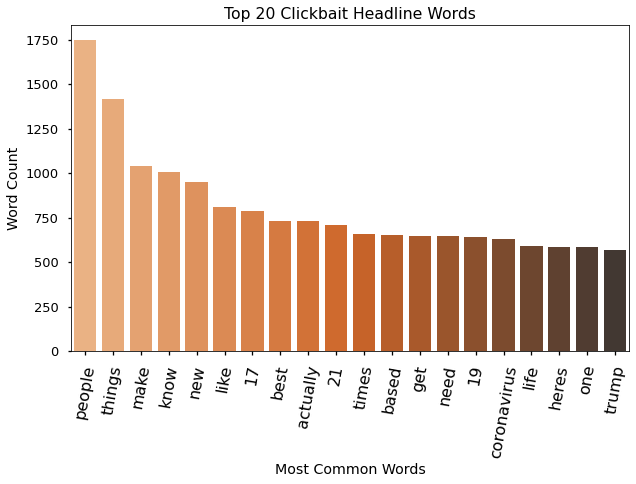

In [ ]:
# Set the style for the plots using seaborn
plt.style.use('seaborn-talk')

# Create a bar plot to visualize the top 20 most common clickbait words
word_freq_figure1 = plt.figure(figsize=(10,6))
sns.barplot(cb_bar_words, cb_bar_counts, palette='Oranges_d')
plt.xticks(fontsize=16, rotation=80)
plt.title('Top 20 Clickbait Headline Words')
plt.xlabel('Most Common Words')
plt.ylabel('Word Count')
plt.show()

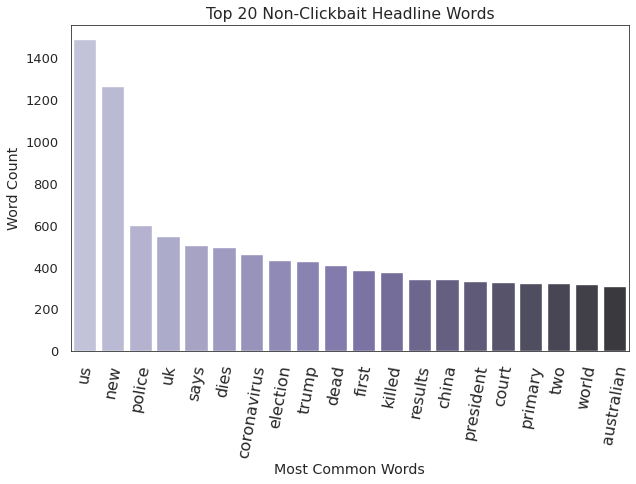

In [ ]:
# Create a bar plot to visualize the top 20 most common non-clickbait words
word_freq_figure1 = plt.figure(figsize=(10,6))
sns.barplot(noncb_bar_words, noncb_bar_counts, palette='Purples_d')
plt.xticks(fontsize=16, rotation=80)
plt.title('Top 20 Non-Clickbait Headline Words')
plt.xlabel('Most Common Words')
plt.ylabel('Word Count')
plt.show()

In [ ]:
# Getting data into a dictionary
clickbait_dictionary = dict(zip(cb_bar_words, cb_bar_counts))
nonclickbait_dictionary = dict(zip(noncb_bar_words, noncb_bar_counts))

# Combine the top words and their frequencies into dictionaries for word cloud generation
clickbait_dictionary = dict(zip(cb_bar_words, cb_bar_counts))
nonclickbait_dictionary = dict(zip(noncb_bar_words, noncb_bar_counts))

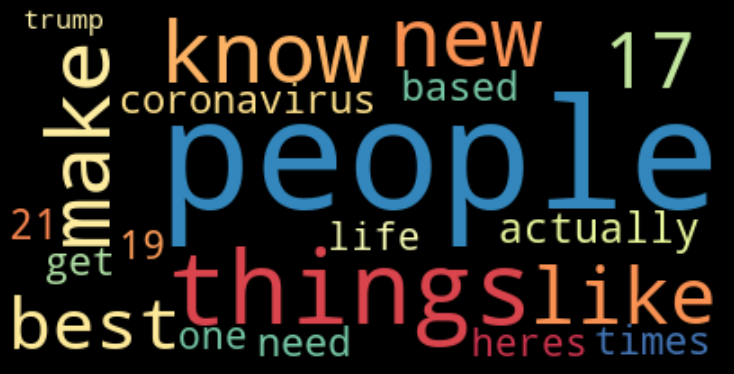

In [ ]:
# Generate and display a word cloud for clickbait words
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(clickbait_dictionary)
plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

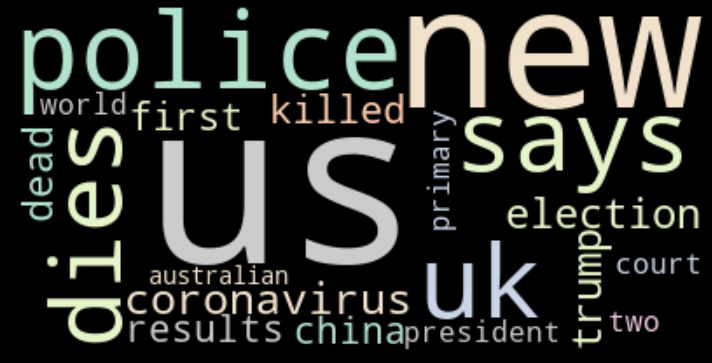

In [ ]:
# Generate and display a word cloud for non-clickbait words
wordcloud = WordCloud(colormap='Pastel2').generate_from_frequencies(nonclickbait_dictionary)
plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

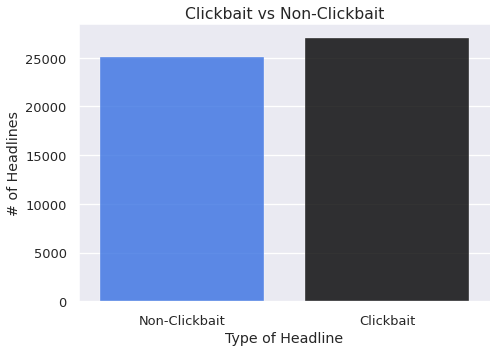

In [ ]:
# Visualize the frequency of each class (clickbait vs non-clickbait) in the dataset
sns.set_style('darkgrid')
plt.figure(figsize=(7,5))
fig1 = sns.countplot(df['class'], alpha=0.80, palette=['#1a66ff', 'black'])
plt.title('Clickbait vs Non-Clickbait')
plt.ylabel('# of Headlines')
plt.xlabel('Type of Headline')
fig1.set(xticklabels=['Non-Clickbait', 'Clickbait'])
plt.tight_layout()
plt.show()

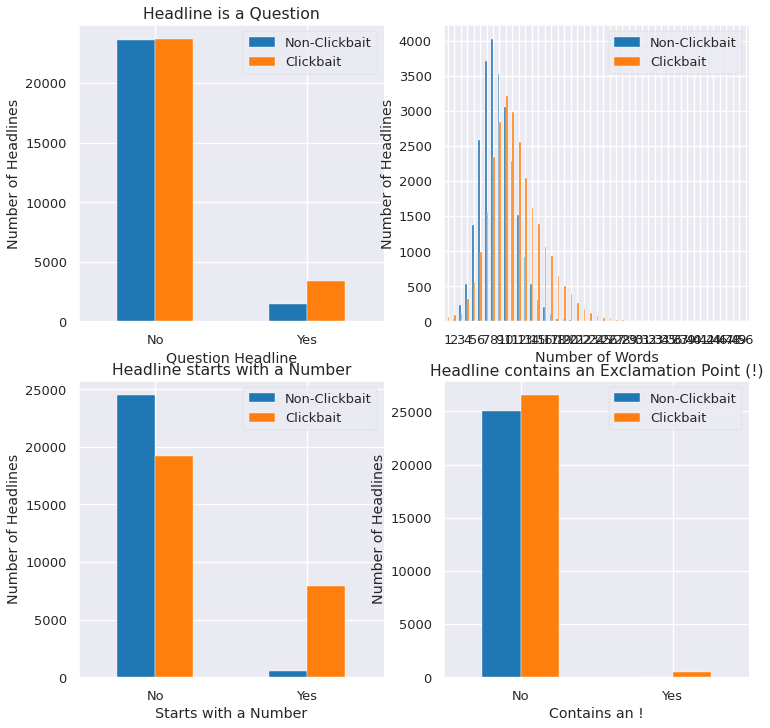

In [ ]:
# Set up the figure for multiple subplots
figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

# Plot the distribution of headlines classified as a question vs not a question
plot = df.groupby('question')['class'].value_counts().unstack().plot.bar(ax=axes[0,0], rot=0)
plot.set_title('Headline is a Question')
plot.set_xlabel('Question Headline')
plot.set_ylabel('Number of Headlines')
plot.legend(labels=['Non-Clickbait', 'Clickbait'])

# Plot the distribution of headlines by the number of words they contain
plot = df.groupby('headline_words')['class'].value_counts().unstack().plot.bar(ax=axes[0,1], rot=0)
plot.set_xlabel('Number of Words')
plot.set_ylabel('Number of Headlines')
plot.legend(labels=['Non-Clickbait', 'Clickbait'])

# Plot the distribution of headlines that start with a number
plot = df.groupby('starts_with_num')['class'].value_counts().unstack().plot.bar(ax=axes[1,0], rot=0)
plot.set_title('Headline starts with a Number')
plot.set_xlabel('Starts with a Number')
plot.set_ylabel('Number of Headlines')
plot.legend(labels=['Non-Clickbait', 'Clickbait'])

# Plot the distribution of headlines that contain an exclamation point
plot = df.groupby('exclamation')['class'].value_counts().unstack().plot.bar(ax=axes[1,1], rot=0)
plot.set_title('Headline contains an Exclamation Point (!)')
plot.set_xlabel('Contains an !')
plot.set_ylabel('Number of Headlines')
plot.legend(labels=['Non-Clickbait', 'Clickbait'])

# Apply the ggplot style for aesthetics
style.use('ggplot')
plt.show()

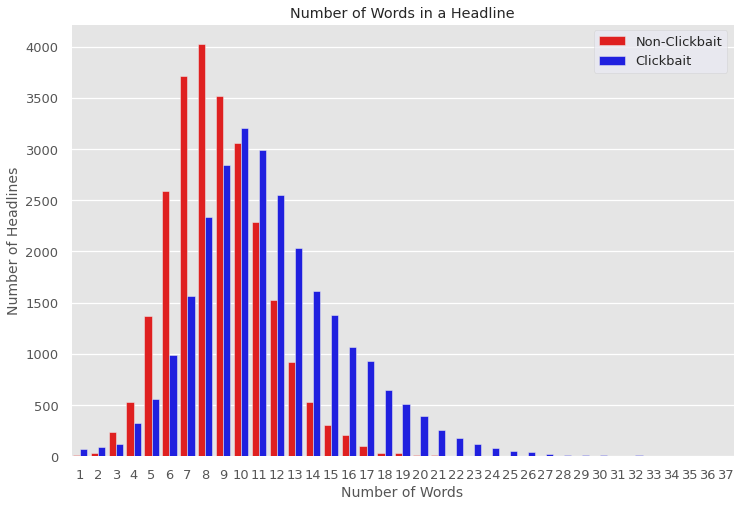

In [ ]:
# Create a count plot comparing the number of words in headlines for both classes
df_words = df[df['headline_words'] < 38]
sns.countplot(df_words['headline_words'], hue=df_words['class'], palette=['red', 'blue'])
plt.title('Number of Words in a Headline')
plt.xlabel('Number of Words', size=14)
plt.ylabel('Number of Headlines', size=14)
plt.legend(labels=['Non-Clickbait', 'Clickbait'], loc='upper right')
plt.tight_layout()
plt.show()